In [1]:
import gc
import os
import warnings
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import multiprocessing

from keras import backend as K
warnings.filterwarnings(action='ignore')

K.image_data_format()

Using TensorFlow backend.


'channels_last'

In [2]:
params = {
    # Generator Parameter
    'random_state': 2,
    'rotation_range': 10,
#     'rescale': 1./255,
    'width_shift_range': 0.20,
    'height_shift_range': 0.20,
    'shear_range': 0.20,
    'zoom_range': 0.20,
    'horizontal_flip': True,
    'brightness_range': (0.7, 1.5),
    # Model Parameter
    'img_size': (299, 299),
    'input_shape': (299, 299, 3),
#     'nb_train_samples': len(X_train),
#     'nb_validation_samples': len(X_val),
#     'nb_test_samples': len(df_test),
#     'train_epochs': 10
    'batch_size': 16,
    'nb_workers': multiprocessing.cpu_count() // 2
}

In [3]:
# 혹 다른 데이터 셋 추가(Pretrained Model Weights)로 인해 PATH가 변경된다면 아래 PATH를 수정
DATA_PATH = 'E:\\data\\2019-3rd-ml-month-with-kakr'
os.listdir(DATA_PATH)

['class.csv',
 'cropped_test',
 'cropped_train',
 'resnet_0.83881',
 'sample_submission.csv',
 'submission.csv',
 'test',
 'test.csv',
 'train',
 'train.csv']

In [4]:
# 이미지 폴더 경로
TRAIN_IMG_PATH = os.path.join(DATA_PATH, 'cropped_train')
TEST_IMG_PATH = os.path.join(DATA_PATH, 'cropped_test')

# CSV 파일 경로
df_train = pd.read_csv(os.path.join(DATA_PATH, 'train.csv'))
df_test = pd.read_csv(os.path.join(DATA_PATH, 'test.csv'))
df_class = pd.read_csv(os.path.join(DATA_PATH, 'class.csv'))

In [5]:
df_train["class"] = df_train["class"].astype('str')

df_train = df_train[['img_file', 'class']]
df_test = df_test[['img_file']]

In [6]:
from sklearn.model_selection import train_test_split

def train_val_split(params, df_train):   

    its = np.arange(df_train.shape[0])
    train_idx, val_idx = train_test_split(its, train_size=0.8, random_state=params['random_state'])

    X_train = df_train.iloc[train_idx, :]
    X_val = df_train.iloc[val_idx, :]
    
    params['random_state'] += 10
    
    return X_train, X_val

def train_val_split_fixed(params, df_train, i):
    its = np.arrange(df_train.shape[0])
    chunks = [its[j::n] for j in range(5)]
    
    X_val = df_train[chunks[i]]
    chunks.pop(i)
    X_train = df_train[np.reshape(chunks, -1)]
    
    return X_train, X_val

In [7]:
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
# from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.preprocessing.image import ImageDataGenerator

def make_generator(params, X_train, X_val):
    # Define Generator config
    train_datagen = ImageDataGenerator(
        rotation_range=params['rotation_range'],
    #     rescale=params['rescale'],
        width_shift_range=params['width_shift_range'],
        height_shift_range=params['height_shift_range'],
        shear_range=params['shear_range'],
        zoom_range=params['zoom_range'],
        horizontal_flip=params['horizontal_flip'],
        brightness_range=params['brightness_range'],
        preprocessing_function=preprocess_input)

    val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

    # Make Generator
    train_generator = train_datagen.flow_from_dataframe(
        dataframe=X_train, 
        directory=TRAIN_IMG_PATH,
        x_col='img_file',
        y_col='class',
        target_size=params['img_size'],
        color_mode='rgb',
        class_mode='categorical',
        batch_size=params['batch_size'],
        seed=42
    )

    validation_generator = val_datagen.flow_from_dataframe(
        dataframe=X_val, 
        directory=TRAIN_IMG_PATH,
        x_col='img_file',
        y_col='class',
        target_size=params['img_size'],
        color_mode='rgb',
        class_mode='categorical',
        batch_size=params['batch_size'],
        shuffle=False
    )
    return train_generator, validation_generator

In [8]:
def get_steps(num_samples, batch_size):
    if (num_samples % batch_size) > 0 :
        return (num_samples // batch_size) + 1
    else:
        return num_samples // batch_size

In [9]:
cnn_model = InceptionResNetV2(include_top=False, input_shape=params['input_shape'])
# cnn_model.summary()

Instructions for updating:
Colocations handled automatically by placer.


In [10]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, GlobalAveragePooling2D

# for layer in cnn_model.layers:
#     layer.trainable = False
#     print(layer,layer.trainable)

model = Sequential()
model.add(cnn_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(196, activation='softmax', kernel_initializer='he_normal'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Model)  (None, 8, 8, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1536)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 196)               301252    
Total params: 54,637,988
Trainable params: 54,577,444
Non-trainable params: 60,544
_________________________________________________________________


In [11]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [ ]:
%%time
from keras.callbacks import ModelCheckpoint, EarlyStopping

filepath = os.path.join(DATA_PATH, 'inception_resnet_v2_ep{epoch:03d}_vloss-{val_loss:.4f}_vacc-{val_acc:.4f}.h5')

checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True)
# earlystop = EarlyStopping(monitor='val_acc', min_delta=0, patience=5, verbose=1, mode='auto')

# callback_list = [checkpoint, earlystop]
callbacks = [checkpoint]


histories = []

for i in range(5):
    print(params)
    
    X_train, X_val = train_val_split(params, df_train)
    train_generator, validation_generator = make_generator(params, X_train, X_val)
    
    params.update({
        'nb_train_samples': len(X_train),
        'nb_validation_samples': len(X_val)
    })
    
    histories.append(
        model.fit_generator(
            train_generator,
            steps_per_epoch=get_steps(params['nb_train_samples'], params['batch_size']),
            epochs=(2 * i) + 10,
            validation_data=validation_generator,
            validation_steps=get_steps(params['nb_validation_samples'], params['batch_size']),
            callbacks=callbacks,
            workers=params['nb_workers'],
            initial_epoch=2 * i)
)
gc.collect()

{'random_state': 2, 'rotation_range': 10, 'width_shift_range': 0.2, 'height_shift_range': 0.2, 'shear_range': 0.2, 'zoom_range': 0.2, 'horizontal_flip': True, 'brightness_range': (0.7, 1.5), 'img_size': (299, 299), 'input_shape': (299, 299, 3), 'batch_size': 16, 'nb_workers': 6}
Found 8012 images belonging to 196 classes.
Found 2004 images belonging to 196 classes.
Instructions for updating:
Use tf.cast instead.
Epoch 1/10
501/501 [==============================] - 411s 821ms/step - loss: 5.2871 - acc: 0.0089 - val_loss: 5.2195 - val_acc: 0.0105

Epoch 00001: val_acc improved from -inf to 0.01048, saving model to E:\data\2019-3rd-ml-month-with-kakr\inception_resnet_v2_ep001_vloss-5.2195_vacc-0.0105.h5
Epoch 2/10
501/501 [==============================] - 364s 726ms/step - loss: 5.1645 - acc: 0.0126 - val_loss: 12.4371 - val_acc: 0.0050

Epoch 00002: val_acc did not improve from 0.01048
Epoch 3/10
501/501 [==============================] - 367s 732ms/step - loss: 4.9606 - acc: 0.0247 - 

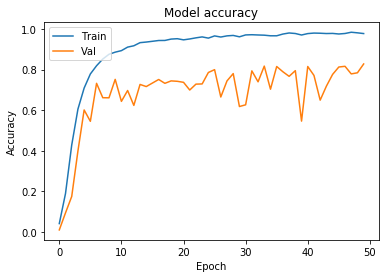

In [16]:
# Plot training & validation accuracy values 
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

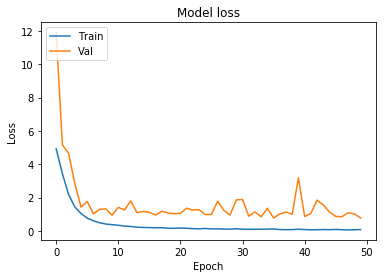

In [17]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [13]:
%%time
from keras.models import load_model

params.update({
    'nb_test_samples': len(df_test)
})

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=df_test,
    directory=TEST_IMG_PATH,
    x_col='img_file',
    y_col=None,
    target_size=params['img_size'],
    color_mode='rgb',
    class_mode=None,
    batch_size=params['batch_size'],
    shuffle=False)

model = load_model(os.path.join(DATA_PATH, 'resnet50_val_ep04_loss-0.1790_acc-0.9421.h5'))

prediction = model.predict_generator(
    generator = test_generator,
    steps = get_steps(params['nb_test_samples'], params['batch_size']),
    verbose=1,
    workers=params['nb_workers']
)

Found 6169 images.
155/155 [==============================] - 30s 191ms/step
Wall time: 1min 17s


In [14]:
predicted_class_indices=np.argmax(prediction, axis=1)

# Generator class dictionary mapping
labels = (train_generator.class_indices)
labels = dict((v, k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

submission = pd.read_csv(os.path.join(DATA_PATH, 'sample_submission.csv'))
submission['class'] = predictions
submission.to_csv(os.path.join(DATA_PATH, 'resnet50_val_ep04_loss-0.1790_acc-0.9421.csv'), index=False)
submission.head()

,img_file,class
0,test_00001.jpg,124
1,test_00002.jpg,98
2,test_00003.jpg,157
3,test_00004.jpg,94
4,test_00005.jpg,18


#### **Reference:**
https://medium.com/@vijayabhaskar96/tutorial-on-keras-flow-from-dataframe-1fd4493d237c  
https://keras.io/  
http://www.arxiv.org/abs/1512.03385  
https://pillow.readthedocs.io/en/stable/  
https://www.kaggle.com/guglielmocamporese/macro-f1-score-keras